# Tutorial for COMP7606 Assignment 1

In this tutorial, I will show you how to
- train a baseline model for cat pose estimation

This tutorial only contains some basic usage of MMPose. 
Please learn more about MMPose at https://mmpose.readthedocs.io/en/latest/.

Let's start!

## Install MMPose

We recommend to use a conda environment to install mmpose and its dependencies. And compilers `nvcc` and `gcc` are required.

In [1]:
# check NVCC version
!nvcc -V

# check GCC version
!gcc --version

# check python in conda environment
!which python

/bin/bash: nvcc: command not found
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

/userhome/eee/smehra2/anaconda3/envs/open-mmlab/bin/python


In [8]:
# install pytorch
!pip install torch

# install mmcv-full. Please follow the instruction (https://github.com/open-mmlab/mmcv) to install mmcv-full.
!pip install mmcv-full==1.3.18 -f https://download.openmmlab.com/mmcv/dist/cu102/torch1.10.0/index.html

# install mmdet for inference demo
!pip install mmdet

# clone mmpose repo
!rm -rf mmpose
!git clone https://github.com/open-mmlab/mmpose.git

# clone necessary files for this assignment
!rm -rf COMP7606
!git clone https://github.com/jin-s13/COMP7606.git

%cd mmpose

# install mmpose dependencies
!pip install -r requirements.txt

# install mmpose in develop mode
!pip install -e .

Looking in links: https://download.openmmlab.com/mmcv/dist/cu102/torch1.10.0/index.html
Cloning into 'mmpose'...
remote: Enumerating objects: 17911, done.
remote: Counting objects: 100% (2835/2835), done.
remote: Compressing objects: 100% (1147/1147), done.
remote: Total 17911 (delta 1830), reused 2410 (delta 1656), pack-reused 15076
Receiving objects: 100% (17911/17911), 26.15 MiB | 14.95 MiB/s, done.
Resolving deltas: 100% (12401/12401), done.
Checking out files: 100% (1483/1483), done.
Cloning into 'COMP7606'...
remote: Enumerating objects: 36, done.
remote: Total 36 (delta 0), reused 0 (delta 0), pack-reused 36
Unpacking objects: 100% (36/36), done.
/userhome/eee/smehra2/COMP7606/mmpose
Ignoring dataclasses: markers 'python_version == "3.6"' don't match your environment
  Cloning https://github.com/svenkreiss/poseval.git to /tmp/.smehra2/pip-install-nk11niq1/poseval_96663b324fb5436a909e1d985bc438d4
  Running command git clone -q https://github.com/svenkreiss/poseval.git /tmp/.smehr

In [3]:
# Check Pytorch installation
import torch, torchvision
print('torch version:', torch.__version__, torch.cuda.is_available())
print('torchvision version:', torchvision.__version__)

# Check MMPose installation
import mmpose
print('mmpose version:', mmpose.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print('cuda version:', get_compiling_cuda_version())
print('compiler information:', get_compiler_version())

torch version: 1.11.0+cu102 True
torchvision version: 0.12.0+cu102
mmpose version: 0.24.0
cuda version: 10.2
compiler information: GCC 7.3


In [10]:
!pip install tensorboard tensorboardX

  Using cached importlib_metadata-4.11.3-py3-none-any.whl (18 kB)
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.2.0
    Uninstalling importlib-metadata-4.2.0:
      Successfully uninstalled importlib-metadata-4.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flake8 4.0.1 requires importlib-metadata<4.3; python_version < "3.8", but you have importlib-metadata 4.11.3 which is incompatible.


## Train a cat pose estimation model 

To train a cat pose estimation model on a customized dataset with MMPose, there are usually three steps:
1. Support the dataset in MMPose
1. Create a config
1. Perform training and evaluation

### Add a new dataset

There are two methods to support a customized dataset in MMPose. The first one is to convert the data to a supported format (e.g. COCO) and use the corresponding dataset class (e.g. TopdownCOCODataset), as described in the [document](https://mmpose.readthedocs.io/en/latest/tutorials/2_new_dataset.html#reorganize-dataset-to-existing-format). The second one is to add a new dataset class. In this tutorial, we give an example of the second method.

We first download the dataset, which contains 1328 images (1000 for training, 128 for validation and 200 for testing).

In [11]:
# download dataset
%mkdir data
%mkdir data/cats
%cp ../COMP7606/Cats.tar data/cats
%cd data/cats
!tar -xf Cats.tar
%cd ../../

/userhome/eee/smehra2/COMP7606/mmpose/data/cats
/userhome/eee/smehra2/COMP7606/mmpose


In [12]:
# The <_base_/cats.py> contains the dataset information, i.e. the keypoint definition, flip pairs, and sigmas for evaluation.
!cp ../COMP7606/configs/_base_/cats.py configs/_base_/datasets/ 
# The <configs/cats/res50_cats_128x128.py> is a baseline config file. You can use this to train/evaluate the model. 
# But the performance of the baseline model is not good enough. You should try to improve it!
!cp -r ../COMP7606/configs/cats configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/ 

After downloading the data, we implement a new dataset class to load data samples for model training and validation. In this assignment, we are going to train a top-down pose estimation model (refer to [Top-down Pose Estimation](https://github.com/open-mmlab/mmpose/tree/master/configs/body/2d_kpt_sview_rgb_img/topdown_heatmap#readme) for a brief introduction), the new dataset class inherits `AnimalAP10KDataset`.

In [2]:
import json
import os
import os.path as osp
from collections import OrderedDict

import numpy as np

from mmpose.core.evaluation.top_down_eval import (keypoint_nme,
                                                  keypoint_pck_accuracy)
from mmpose.datasets.builder import DATASETS
from mmpose.datasets.datasets.animal import AnimalAP10KDataset


@DATASETS.register_module()
class AnimalCatsDataset(AnimalAP10KDataset):

	def __init__(self,
				 ann_file,
				 img_prefix,
				 data_cfg,
				 pipeline,
				 dataset_info=None,
				 test_mode=False):
		super().__init__(
			ann_file, img_prefix, data_cfg, pipeline, dataset_info, test_mode=test_mode)

### Create a training config file

In the next step, we create a config file which configures the model, dataset and runtime settings. More information can be found at [Learn about Configs](https://mmpose.readthedocs.io/en/latest/tutorials/0_config.html). A common practice to create a config file is deriving from a existing one. In this tutorial, we load a config file that trains a ResNet on COCO dataset, and modify it to adapt to the Cats dataset.

Note that the following config file is just an example to show how to train a model. 
This config file is far from optimal and the baseline model is not good enough. You should try your best to improve it. 

In [4]:
from mmcv import Config
cfg = Config.fromfile(
    #'./configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/cats/hrnet_w48_ap10k_256x256.py'
    #'./configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/cats/res50_cats_128x128.py'
    #'./mmpose/configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/cats/resnetv1d152_coco_256x192.py'
    #'./mmpose/configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/cats/3xrsn50_coco_256x192.py'
    #'./mmpose/configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/cats/hrnet_w48_ap10k_256x256.py'
    './mmpose/configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/cats/hrnet_w32_coco_256x192_coarsedropout.py'
    #'./mmpose/configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/cats/resnetv1d152_coco_256x192.py'
    #'./mmpose/configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/cats/res50_ap10k_256x256.py'
)

# set basic configs
cfg.data_root = 'data/cats'
cfg.work_dir = 'work_dirs/hrnet_w32_coco_256x192_exp'
cfg.gpu_ids = range(1)
cfg.seed = 0

# set log interval
cfg.log_config.interval = 1

# set evaluation configs
cfg.evaluation.interval = 5

# set batch size
cfg.data.samples_per_gpu = 16
cfg.data.val_dataloader = dict(samples_per_gpu=16)
cfg.data.test_dataloader = dict(samples_per_gpu=16)


# set dataset configs
cfg.data.train.type = 'AnimalCatsDataset'
cfg.data.train.ann_file = f'{cfg.data_root}/annotations/train.json'
cfg.data.train.img_prefix = f'{cfg.data_root}/images/'

cfg.data.val.type = 'AnimalCatsDataset'
cfg.data.val.ann_file = f'{cfg.data_root}/annotations/val.json'
cfg.data.val.img_prefix = f'{cfg.data_root}/images/'

cfg.data.test.type = 'AnimalCatsDataset'
cfg.data.test.ann_file = f'{cfg.data_root}/annotations/test_info.json'
cfg.data.test.img_prefix = f'{cfg.data_root}/images/'

print(cfg.pretty_text)


dataset_info = dict(
    dataset_name='cats',
    paper_info=dict(
        title='Assignment for COMP7606',
        year='2022',
        homepage='https://github.com/jin-s13/COMP7606'),
    keypoint_info=dict({
        0:
        dict(
            name='L_Eye', id=0, color=[0, 255, 0], type='upper', swap='R_Eye'),
        1:
        dict(
            name='R_Eye',
            id=1,
            color=[255, 128, 0],
            type='upper',
            swap='L_Eye'),
        2:
        dict(name='Nose', id=2, color=[51, 153, 255], type='upper', swap=''),
        3:
        dict(name='Neck', id=3, color=[51, 153, 255], type='upper', swap=''),
        4:
        dict(
            name='Root of tail',
            id=4,
            color=[51, 153, 255],
            type='lower',
            swap=''),
        5:
        dict(
            name='L_Shoulder',
            id=5,
            color=[51, 153, 255],
            type='upper',
            swap='R_Shoulder'),
        6:
        dict(
  

### Train and Evaluation

In [58]:
from mmpose.datasets import build_dataset
from mmpose.models import build_posenet
from mmpose.apis import train_model
import mmcv
torch.cuda.empty_cache()

# build dataset
datasets = [build_dataset(cfg.data.train)]

# build model
model = build_posenet(cfg.model)

# create work_dir
mmcv.mkdir_or_exist(cfg.work_dir)

# train model
train_model(
    model, datasets, cfg, distributed=False, validate=True, meta=dict())

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
=> num_images: 1000
=> load 1104 samples
load checkpoint from mmcls path: mmcls://resnet152_v1d


2022-03-17 20:06:03,001 - mmpose - INFO - Start running, host: smehra2@gpu2-comp-3, work_dir: /userhome/eee/smehra2/COMP7606/work_dirs/resnetv1d152_coco_256x192
2022-03-17 20:06:03,005 - mmpose - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) TensorboardLoggerHook              
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                      
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) TensorboardLoggerHook              
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook             

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> num_images: 124
=> load 132 samples


2022-03-17 20:06:06,072 - mmpose - INFO - Epoch [1][1/69]	lr: 5.000e-07, eta: 8:46:35, time: 3.053, data_time: 2.631, memory: 4355, heatmap_loss: 0.0020, acc_pose: 0.0499, loss: 0.0020
2022-03-17 20:06:06,315 - mmpose - INFO - Epoch [1][2/69]	lr: 1.499e-06, eta: 4:44:17, time: 0.244, data_time: 0.010, memory: 4355, heatmap_loss: 0.0017, acc_pose: 0.0388, loss: 0.0017
2022-03-17 20:06:06,554 - mmpose - INFO - Epoch [1][3/69]	lr: 2.498e-06, eta: 3:23:15, time: 0.239, data_time: 0.007, memory: 4355, heatmap_loss: 0.0019, acc_pose: 0.0081, loss: 0.0019
2022-03-17 20:06:06,791 - mmpose - INFO - Epoch [1][4/69]	lr: 3.497e-06, eta: 2:42:37, time: 0.237, data_time: 0.005, memory: 4355, heatmap_loss: 0.0019, acc_pose: 0.0152, loss: 0.0019
2022-03-17 20:06:07,013 - mmpose - INFO - Epoch [1][5/69]	lr: 4.496e-06, eta: 2:17:45, time: 0.222, data_time: 0.005, memory: 4355, heatmap_loss: 0.0018, acc_pose: 0.0272, loss: 0.0018
2022-03-17 20:06:07,241 - mmpose - INFO - Epoch [1][6/69]	lr: 5.495e-06, et

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 74.8 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.293
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.722
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.190
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.061
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.292
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.388
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.780
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium 

2022-03-17 20:07:40,596 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_5.pth.
2022-03-17 20:07:40,599 - mmpose - INFO - Best AP is 0.2935 at 5 epoch.
2022-03-17 20:07:40,601 - mmpose - INFO - Epoch(val) [5][9]	AP: 0.2935, AP .5: 0.7217, AP .75: 0.1904, AP (M): 0.0613, AP (L): 0.2924, AR: 0.3879, AR .5: 0.7803, AR .75: 0.3182, AR (M): 0.3200, AR (L): 0.3905
2022-03-17 20:07:43,476 - mmpose - INFO - Epoch [6][1/69]	lr: 3.452e-04, eta: 0:45:39, time: 2.857, data_time: 2.548, memory: 4355, heatmap_loss: 0.0016, acc_pose: 0.3061, loss: 0.0016
2022-03-17 20:07:43,703 - mmpose - INFO - Epoch [6][2/69]	lr: 3.462e-04, eta: 0:45:37, time: 0.228, data_time: 0.010, memory: 4355, heatmap_loss: 0.0010, acc_pose: 0.2931, loss: 0.0010
2022-03-17 20:07:43,923 - mmpose - INFO - Epoch [6][3/69]	lr: 3.472e-04, eta: 0:45:35, time: 0.220, data_time: 0.005, memory: 4355, heatmap_loss: 0.0012, acc_pose: 0.3205, loss: 0.0012
2022-03-17 20:07:44,147 - mmpose - INFO - Epoch [6][4/69]	lr: 3.482e-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 75.2 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...


2022-03-17 20:09:17,513 - mmpose - INFO - The previous best checkpoint /userhome/eee/smehra2/COMP7606/work_dirs/resnetv1d152_coco_256x192/best_AP_epoch_5.pth was removed


DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.378
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.778
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.326
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.085
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.382
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.449
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.818
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.447
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.300
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.454


2022-03-17 20:09:20,491 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_10.pth.
2022-03-17 20:09:20,493 - mmpose - INFO - Best AP is 0.3778 at 10 epoch.
2022-03-17 20:09:20,495 - mmpose - INFO - Epoch(val) [10][9]	AP: 0.3778, AP .5: 0.7781, AP .75: 0.3261, AP (M): 0.0850, AP (L): 0.3824, AR: 0.4492, AR .5: 0.8182, AR .75: 0.4470, AR (M): 0.3000, AR (L): 0.4540
2022-03-17 20:09:23,408 - mmpose - INFO - Epoch [11][1/69]	lr: 5.000e-04, eta: 0:43:20, time: 2.901, data_time: 2.633, memory: 4355, heatmap_loss: 0.0010, acc_pose: 0.3922, loss: 0.0010
2022-03-17 20:09:23,674 - mmpose - INFO - Epoch [11][2/69]	lr: 5.000e-04, eta: 0:43:20, time: 0.267, data_time: 0.013, memory: 4355, heatmap_loss: 0.0012, acc_pose: 0.3657, loss: 0.0012
2022-03-17 20:09:23,907 - mmpose - INFO - Epoch [11][3/69]	lr: 5.000e-04, eta: 0:43:19, time: 0.233, data_time: 0.007, memory: 4355, heatmap_loss: 0.0008, acc_pose: 0.4408, loss: 0.0008
2022-03-17 20:09:24,134 - mmpose - INFO - Epoch [11][4/69]	lr: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 75.9 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.422
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.805
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.405
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.141
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.429
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.504
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.848
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.515
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium 

2022-03-17 20:10:54,737 - mmpose - INFO - The previous best checkpoint /userhome/eee/smehra2/COMP7606/work_dirs/resnetv1d152_coco_256x192/best_AP_epoch_10.pth was removed
2022-03-17 20:10:57,858 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_15.pth.
2022-03-17 20:10:57,859 - mmpose - INFO - Best AP is 0.4220 at 15 epoch.
2022-03-17 20:10:57,862 - mmpose - INFO - Epoch(val) [15][9]	AP: 0.4220, AP .5: 0.8053, AP .75: 0.4046, AP (M): 0.1410, AP (L): 0.4293, AR: 0.5038, AR .5: 0.8485, AR .75: 0.5152, AR (M): 0.2800, AR (L): 0.5151
2022-03-17 20:11:00,712 - mmpose - INFO - Epoch [16][1/69]	lr: 5.000e-04, eta: 0:41:36, time: 2.834, data_time: 2.545, memory: 4355, heatmap_loss: 0.0010, acc_pose: 0.5400, loss: 0.0010
2022-03-17 20:11:00,961 - mmpose - INFO - Epoch [16][2/69]	lr: 5.000e-04, eta: 0:41:35, time: 0.249, data_time: 0.013, memory: 4355, heatmap_loss: 0.0009, acc_pose: 0.5117, loss: 0.0009
2022-03-17 20:11:01,189 - mmpose - INFO - Epoch [16][3/69]	lr: 5.000e-04, eta:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 80.9 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.06s).
Accumulating evaluation results...


2022-03-17 20:12:34,794 - mmpose - INFO - The previous best checkpoint /userhome/eee/smehra2/COMP7606/work_dirs/resnetv1d152_coco_256x192/best_AP_epoch_15.pth was removed


DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.495
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.860
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.491
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.213
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.497
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.558
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.886
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.561
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.563


2022-03-17 20:12:37,788 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_20.pth.
2022-03-17 20:12:37,792 - mmpose - INFO - Best AP is 0.4948 at 20 epoch.
2022-03-17 20:12:37,794 - mmpose - INFO - Epoch(val) [20][9]	AP: 0.4948, AP .5: 0.8602, AP .75: 0.4906, AP (M): 0.2135, AP (L): 0.4971, AR: 0.5576, AR .5: 0.8864, AR .75: 0.5606, AR (M): 0.5000, AR (L): 0.5627
2022-03-17 20:12:40,672 - mmpose - INFO - Epoch [21][1/69]	lr: 5.000e-04, eta: 0:39:57, time: 2.863, data_time: 2.566, memory: 4355, heatmap_loss: 0.0010, acc_pose: 0.4654, loss: 0.0010
2022-03-17 20:12:40,925 - mmpose - INFO - Epoch [21][2/69]	lr: 5.000e-04, eta: 0:39:56, time: 0.254, data_time: 0.011, memory: 4355, heatmap_loss: 0.0008, acc_pose: 0.5264, loss: 0.0008
2022-03-17 20:12:41,171 - mmpose - INFO - Epoch [21][3/69]	lr: 5.000e-04, eta: 0:39:56, time: 0.245, data_time: 0.005, memory: 4355, heatmap_loss: 0.0011, acc_pose: 0.4477, loss: 0.0011
2022-03-17 20:12:41,419 - mmpose - INFO - Epoch [21][4/69]	lr: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 80.2 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...


2022-03-17 20:14:11,389 - mmpose - INFO - Epoch(val) [25][9]	AP: 0.4922, AP .5: 0.8475, AP .75: 0.4951, AP (M): 0.2031, AP (L): 0.4912, AR: 0.5720, AR .5: 0.8788, AR .75: 0.5909, AR (M): 0.6000, AR (L): 0.5738


DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.492
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.847
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.495
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.203
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.491
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.572
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.879
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.591
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.574


2022-03-17 20:14:14,245 - mmpose - INFO - Epoch [26][1/69]	lr: 5.000e-04, eta: 0:38:19, time: 2.846, data_time: 2.520, memory: 4355, heatmap_loss: 0.0009, acc_pose: 0.5118, loss: 0.0009
2022-03-17 20:14:14,471 - mmpose - INFO - Epoch [26][2/69]	lr: 5.000e-04, eta: 0:38:19, time: 0.227, data_time: 0.009, memory: 4355, heatmap_loss: 0.0010, acc_pose: 0.4253, loss: 0.0010
2022-03-17 20:14:14,691 - mmpose - INFO - Epoch [26][3/69]	lr: 5.000e-04, eta: 0:38:18, time: 0.220, data_time: 0.005, memory: 4355, heatmap_loss: 0.0011, acc_pose: 0.4245, loss: 0.0011
2022-03-17 20:14:14,917 - mmpose - INFO - Epoch [26][4/69]	lr: 5.000e-04, eta: 0:38:18, time: 0.226, data_time: 0.005, memory: 4355, heatmap_loss: 0.0009, acc_pose: 0.4790, loss: 0.0009
2022-03-17 20:14:15,134 - mmpose - INFO - Epoch [26][5/69]	lr: 5.000e-04, eta: 0:38:17, time: 0.217, data_time: 0.005, memory: 4355, heatmap_loss: 0.0006, acc_pose: 0.5388, loss: 0.0006
2022-03-17 20:14:15,369 - mmpose - INFO - Epoch [26][6/69]	lr: 5.000e-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 74.8 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.472
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.842
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.522
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.167
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.466
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.562
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.886
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.636
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium 

2022-03-17 20:15:48,485 - mmpose - INFO - Epoch(val) [30][9]	AP: 0.4722, AP .5: 0.8423, AP .75: 0.5215, AP (M): 0.1666, AP (L): 0.4664, AR: 0.5621, AR .5: 0.8864, AR .75: 0.6364, AR (M): 0.6800, AR (L): 0.5571
2022-03-17 20:15:51,327 - mmpose - INFO - Epoch [31][1/69]	lr: 5.000e-04, eta: 0:36:44, time: 2.830, data_time: 2.504, memory: 4355, heatmap_loss: 0.0009, acc_pose: 0.5865, loss: 0.0009
2022-03-17 20:15:51,556 - mmpose - INFO - Epoch [31][2/69]	lr: 5.000e-04, eta: 0:36:44, time: 0.231, data_time: 0.011, memory: 4355, heatmap_loss: 0.0009, acc_pose: 0.5090, loss: 0.0009
2022-03-17 20:15:51,793 - mmpose - INFO - Epoch [31][3/69]	lr: 5.000e-04, eta: 0:36:44, time: 0.236, data_time: 0.006, memory: 4355, heatmap_loss: 0.0007, acc_pose: 0.5654, loss: 0.0007
2022-03-17 20:15:52,013 - mmpose - INFO - Epoch [31][4/69]	lr: 5.000e-04, eta: 0:36:43, time: 0.221, data_time: 0.006, memory: 4355, heatmap_loss: 0.0008, acc_pose: 0.4954, loss: 0.0008
2022-03-17 20:15:52,237 - mmpose - INFO - Epoc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 75.7 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.511
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.889
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.527
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.218
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.510
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.588
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.902
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.629
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium 

2022-03-17 20:17:23,857 - mmpose - INFO - The previous best checkpoint /userhome/eee/smehra2/COMP7606/work_dirs/resnetv1d152_coco_256x192/best_AP_epoch_20.pth was removed
2022-03-17 20:17:27,173 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_35.pth.
2022-03-17 20:17:27,175 - mmpose - INFO - Best AP is 0.5113 at 35 epoch.
2022-03-17 20:17:27,176 - mmpose - INFO - Epoch(val) [35][9]	AP: 0.5113, AP .5: 0.8890, AP .75: 0.5275, AP (M): 0.2181, AP (L): 0.5097, AR: 0.5879, AR .5: 0.9015, AR .75: 0.6288, AR (M): 0.6200, AR (L): 0.5873
2022-03-17 20:17:30,056 - mmpose - INFO - Epoch [36][1/69]	lr: 5.000e-04, eta: 0:35:16, time: 2.870, data_time: 2.549, memory: 4355, heatmap_loss: 0.0009, acc_pose: 0.5972, loss: 0.0009
2022-03-17 20:17:30,280 - mmpose - INFO - Epoch [36][2/69]	lr: 5.000e-04, eta: 0:35:15, time: 0.224, data_time: 0.008, memory: 4355, heatmap_loss: 0.0006, acc_pose: 0.8187, loss: 0.0006
2022-03-17 20:17:30,506 - mmpose - INFO - Epoch [36][3/69]	lr: 5.000e-04, eta:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 79.4 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.536
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.867
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.596
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.280
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.536
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.600
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.879
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.667
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium 

2022-03-17 20:19:04,893 - mmpose - INFO - The previous best checkpoint /userhome/eee/smehra2/COMP7606/work_dirs/resnetv1d152_coco_256x192/best_AP_epoch_35.pth was removed
2022-03-17 20:19:07,898 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_40.pth.
2022-03-17 20:19:07,900 - mmpose - INFO - Best AP is 0.5361 at 40 epoch.
2022-03-17 20:19:07,901 - mmpose - INFO - Epoch(val) [40][9]	AP: 0.5361, AP .5: 0.8669, AP .75: 0.5961, AP (M): 0.2802, AP (L): 0.5362, AR: 0.6000, AR .5: 0.8788, AR .75: 0.6667, AR (M): 0.6200, AR (L): 0.6016
2022-03-17 20:19:10,786 - mmpose - INFO - Epoch [41][1/69]	lr: 5.000e-04, eta: 0:33:44, time: 2.871, data_time: 2.587, memory: 4355, heatmap_loss: 0.0010, acc_pose: 0.5615, loss: 0.0010
2022-03-17 20:19:11,039 - mmpose - INFO - Epoch [41][2/69]	lr: 5.000e-04, eta: 0:33:43, time: 0.253, data_time: 0.010, memory: 4355, heatmap_loss: 0.0005, acc_pose: 0.4862, loss: 0.0005
2022-03-17 20:19:11,281 - mmpose - INFO - Epoch [41][3/69]	lr: 5.000e-04, eta:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 76.6 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...


2022-03-17 20:20:42,762 - mmpose - INFO - Epoch(val) [45][9]	AP: 0.5359, AP .5: 0.8761, AP .75: 0.5609, AP (M): 0.2549, AP (L): 0.5345, AR: 0.5992, AR .5: 0.9091, AR .75: 0.6364, AR (M): 0.6400, AR (L): 0.5992


DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.536
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.876
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.561
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.255
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.534
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.599
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.909
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.636
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.640
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.599


2022-03-17 20:20:45,587 - mmpose - INFO - Epoch [46][1/69]	lr: 5.000e-04, eta: 0:32:12, time: 2.815, data_time: 2.513, memory: 4355, heatmap_loss: 0.0011, acc_pose: 0.4228, loss: 0.0011
2022-03-17 20:20:45,815 - mmpose - INFO - Epoch [46][2/69]	lr: 5.000e-04, eta: 0:32:12, time: 0.229, data_time: 0.011, memory: 4355, heatmap_loss: 0.0008, acc_pose: 0.6993, loss: 0.0008
2022-03-17 20:20:46,051 - mmpose - INFO - Epoch [46][3/69]	lr: 5.000e-04, eta: 0:32:12, time: 0.236, data_time: 0.007, memory: 4355, heatmap_loss: 0.0008, acc_pose: 0.6121, loss: 0.0008
2022-03-17 20:20:46,276 - mmpose - INFO - Epoch [46][4/69]	lr: 5.000e-04, eta: 0:32:11, time: 0.225, data_time: 0.005, memory: 4355, heatmap_loss: 0.0009, acc_pose: 0.5705, loss: 0.0009
2022-03-17 20:20:46,514 - mmpose - INFO - Epoch [46][5/69]	lr: 5.000e-04, eta: 0:32:11, time: 0.238, data_time: 0.005, memory: 4355, heatmap_loss: 0.0009, acc_pose: 0.5219, loss: 0.0009
2022-03-17 20:20:46,748 - mmpose - INFO - Epoch [46][6/69]	lr: 5.000e-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 79.2 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...


2022-03-17 20:22:20,286 - mmpose - INFO - Epoch(val) [50][9]	AP: 0.5326, AP .5: 0.8822, AP .75: 0.6191, AP (M): 0.3555, AP (L): 0.5338, AR: 0.6008, AR .5: 0.9015, AR .75: 0.6894, AR (M): 0.6200, AR (L): 0.6048


DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.533
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.882
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.619
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.356
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.534
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.601
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.902
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.689
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.620
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.605


2022-03-17 20:22:23,172 - mmpose - INFO - Epoch [51][1/69]	lr: 5.000e-04, eta: 0:30:40, time: 2.877, data_time: 2.559, memory: 4355, heatmap_loss: 0.0005, acc_pose: 0.6563, loss: 0.0005
2022-03-17 20:22:23,410 - mmpose - INFO - Epoch [51][2/69]	lr: 5.000e-04, eta: 0:30:40, time: 0.239, data_time: 0.008, memory: 4355, heatmap_loss: 0.0006, acc_pose: 0.5924, loss: 0.0006
2022-03-17 20:22:23,650 - mmpose - INFO - Epoch [51][3/69]	lr: 5.000e-04, eta: 0:30:39, time: 0.240, data_time: 0.012, memory: 4355, heatmap_loss: 0.0009, acc_pose: 0.5340, loss: 0.0009
2022-03-17 20:22:23,870 - mmpose - INFO - Epoch [51][4/69]	lr: 5.000e-04, eta: 0:30:39, time: 0.220, data_time: 0.006, memory: 4355, heatmap_loss: 0.0011, acc_pose: 0.4994, loss: 0.0011
2022-03-17 20:22:24,086 - mmpose - INFO - Epoch [51][5/69]	lr: 5.000e-04, eta: 0:30:39, time: 0.216, data_time: 0.006, memory: 4355, heatmap_loss: 0.0008, acc_pose: 0.6450, loss: 0.0008
2022-03-17 20:22:24,329 - mmpose - INFO - Epoch [51][6/69]	lr: 5.000e-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 80.0 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*


2022-03-17 20:23:54,467 - mmpose - INFO - Epoch(val) [55][9]	AP: 0.5161, AP .5: 0.8286, AP .75: 0.5549, AP (M): 0.1541, AP (L): 0.5202, AR: 0.5970, AR .5: 0.8712, AR .75: 0.6515, AR (M): 0.5200, AR (L): 0.6048


DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.516
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.829
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.555
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.154
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.520
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.597
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.871
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.652
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.520
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.605


2022-03-17 20:23:57,317 - mmpose - INFO - Epoch [56][1/69]	lr: 5.000e-04, eta: 0:29:07, time: 2.840, data_time: 2.522, memory: 4355, heatmap_loss: 0.0006, acc_pose: 0.6180, loss: 0.0006
2022-03-17 20:23:57,549 - mmpose - INFO - Epoch [56][2/69]	lr: 5.000e-04, eta: 0:29:07, time: 0.233, data_time: 0.007, memory: 4355, heatmap_loss: 0.0006, acc_pose: 0.5012, loss: 0.0006
2022-03-17 20:23:57,772 - mmpose - INFO - Epoch [56][3/69]	lr: 5.000e-04, eta: 0:29:07, time: 0.224, data_time: 0.006, memory: 4355, heatmap_loss: 0.0007, acc_pose: 0.7176, loss: 0.0007
2022-03-17 20:23:57,991 - mmpose - INFO - Epoch [56][4/69]	lr: 5.000e-04, eta: 0:29:06, time: 0.219, data_time: 0.006, memory: 4355, heatmap_loss: 0.0011, acc_pose: 0.4916, loss: 0.0011
2022-03-17 20:23:58,226 - mmpose - INFO - Epoch [56][5/69]	lr: 5.000e-04, eta: 0:29:06, time: 0.235, data_time: 0.005, memory: 4355, heatmap_loss: 0.0009, acc_pose: 0.5920, loss: 0.0009
2022-03-17 20:23:58,456 - mmpose - INFO - Epoch [56][6/69]	lr: 5.000e-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 75.7 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...


2022-03-17 20:25:31,760 - mmpose - INFO - The previous best checkpoint /userhome/eee/smehra2/COMP7606/work_dirs/resnetv1d152_coco_256x192/best_AP_epoch_40.pth was removed


DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.548
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.920
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.604
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.205
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.547
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.620
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.932
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.689
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.620


2022-03-17 20:25:34,680 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_60.pth.
2022-03-17 20:25:34,682 - mmpose - INFO - Best AP is 0.5485 at 60 epoch.
2022-03-17 20:25:34,684 - mmpose - INFO - Epoch(val) [60][9]	AP: 0.5485, AP .5: 0.9199, AP .75: 0.6045, AP (M): 0.2052, AP (L): 0.5467, AR: 0.6205, AR .5: 0.9318, AR .75: 0.6894, AR (M): 0.6000, AR (L): 0.6198
2022-03-17 20:25:37,527 - mmpose - INFO - Epoch [61][1/69]	lr: 5.000e-04, eta: 0:27:35, time: 2.830, data_time: 2.531, memory: 4355, heatmap_loss: 0.0007, acc_pose: 0.7913, loss: 0.0007
2022-03-17 20:25:37,778 - mmpose - INFO - Epoch [61][2/69]	lr: 5.000e-04, eta: 0:27:34, time: 0.253, data_time: 0.015, memory: 4355, heatmap_loss: 0.0008, acc_pose: 0.5955, loss: 0.0008
2022-03-17 20:25:38,003 - mmpose - INFO - Epoch [61][3/69]	lr: 5.000e-04, eta: 0:27:34, time: 0.225, data_time: 0.005, memory: 4355, heatmap_loss: 0.0008, acc_pose: 0.5953, loss: 0.0008
2022-03-17 20:25:38,225 - mmpose - INFO - Epoch [61][4/69]	lr: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 76.9 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...


2022-03-17 20:27:09,040 - mmpose - INFO - Epoch(val) [65][9]	AP: 0.5441, AP .5: 0.9068, AP .75: 0.5509, AP (M): 0.2751, AP (L): 0.5421, AR: 0.6159, AR .5: 0.9242, AR .75: 0.6515, AR (M): 0.6600, AR (L): 0.6159


DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.544
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.907
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.551
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.275
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.542
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.616
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.924
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.652
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.660
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.616


2022-03-17 20:27:11,852 - mmpose - INFO - Epoch [66][1/69]	lr: 5.000e-04, eta: 0:26:03, time: 2.803, data_time: 2.526, memory: 4355, heatmap_loss: 0.0008, acc_pose: 0.7305, loss: 0.0008
2022-03-17 20:27:12,088 - mmpose - INFO - Epoch [66][2/69]	lr: 5.000e-04, eta: 0:26:02, time: 0.236, data_time: 0.010, memory: 4355, heatmap_loss: 0.0009, acc_pose: 0.5922, loss: 0.0009
2022-03-17 20:27:12,324 - mmpose - INFO - Epoch [66][3/69]	lr: 5.000e-04, eta: 0:26:02, time: 0.236, data_time: 0.009, memory: 4355, heatmap_loss: 0.0007, acc_pose: 0.6366, loss: 0.0007
2022-03-17 20:27:12,549 - mmpose - INFO - Epoch [66][4/69]	lr: 5.000e-04, eta: 0:26:02, time: 0.225, data_time: 0.006, memory: 4355, heatmap_loss: 0.0005, acc_pose: 0.7380, loss: 0.0005
2022-03-17 20:27:12,776 - mmpose - INFO - Epoch [66][5/69]	lr: 5.000e-04, eta: 0:26:01, time: 0.227, data_time: 0.006, memory: 4355, heatmap_loss: 0.0007, acc_pose: 0.5807, loss: 0.0007
2022-03-17 20:27:13,011 - mmpose - INFO - Epoch [66][6/69]	lr: 5.000e-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 79.8 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...


2022-03-17 20:28:46,222 - mmpose - INFO - Epoch(val) [70][9]	AP: 0.5420, AP .5: 0.8750, AP .75: 0.5560, AP (M): 0.2680, AP (L): 0.5426, AR: 0.6197, AR .5: 0.9015, AR .75: 0.6742, AR (M): 0.6000, AR (L): 0.6254


DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.542
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.875
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.556
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.268
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.543
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.620
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.902
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.674
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.625


2022-03-17 20:28:49,158 - mmpose - INFO - Epoch [71][1/69]	lr: 5.000e-04, eta: 0:24:30, time: 2.924, data_time: 2.550, memory: 4355, heatmap_loss: 0.0008, acc_pose: 0.6692, loss: 0.0008
2022-03-17 20:28:49,384 - mmpose - INFO - Epoch [71][2/69]	lr: 5.000e-04, eta: 0:24:30, time: 0.229, data_time: 0.013, memory: 4355, heatmap_loss: 0.0008, acc_pose: 0.5879, loss: 0.0008
2022-03-17 20:28:49,622 - mmpose - INFO - Epoch [71][3/69]	lr: 5.000e-04, eta: 0:24:30, time: 0.238, data_time: 0.006, memory: 4355, heatmap_loss: 0.0009, acc_pose: 0.6041, loss: 0.0009
2022-03-17 20:28:49,867 - mmpose - INFO - Epoch [71][4/69]	lr: 5.000e-04, eta: 0:24:29, time: 0.245, data_time: 0.006, memory: 4355, heatmap_loss: 0.0009, acc_pose: 0.6132, loss: 0.0009
2022-03-17 20:28:50,108 - mmpose - INFO - Epoch [71][5/69]	lr: 5.000e-04, eta: 0:24:29, time: 0.241, data_time: 0.006, memory: 4355, heatmap_loss: 0.0007, acc_pose: 0.5966, loss: 0.0007
2022-03-17 20:28:50,330 - mmpose - INFO - Epoch [71][6/69]	lr: 5.000e-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 74.9 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*


2022-03-17 20:30:20,341 - mmpose - INFO - The previous best checkpoint /userhome/eee/smehra2/COMP7606/work_dirs/resnetv1d152_coco_256x192/best_AP_epoch_60.pth was removed


DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.553
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.872
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.634
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.365
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.554
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.611
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.886
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.674
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.613


2022-03-17 20:30:23,569 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_75.pth.
2022-03-17 20:30:23,571 - mmpose - INFO - Best AP is 0.5531 at 75 epoch.
2022-03-17 20:30:23,573 - mmpose - INFO - Epoch(val) [75][9]	AP: 0.5531, AP .5: 0.8715, AP .75: 0.6342, AP (M): 0.3651, AP (L): 0.5538, AR: 0.6106, AR .5: 0.8864, AR .75: 0.6742, AR (M): 0.6000, AR (L): 0.6135
2022-03-17 20:30:26,415 - mmpose - INFO - Epoch [76][1/69]	lr: 5.000e-04, eta: 0:22:58, time: 2.829, data_time: 2.541, memory: 4355, heatmap_loss: 0.0008, acc_pose: 0.6688, loss: 0.0008
2022-03-17 20:30:26,635 - mmpose - INFO - Epoch [76][2/69]	lr: 5.000e-04, eta: 0:22:58, time: 0.222, data_time: 0.009, memory: 4355, heatmap_loss: 0.0007, acc_pose: 0.6164, loss: 0.0007
2022-03-17 20:30:26,857 - mmpose - INFO - Epoch [76][3/69]	lr: 5.000e-04, eta: 0:22:57, time: 0.222, data_time: 0.005, memory: 4355, heatmap_loss: 0.0009, acc_pose: 0.5944, loss: 0.0009
2022-03-17 20:30:27,080 - mmpose - INFO - Epoch [76][4/69]	lr: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 75.9 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...


2022-03-17 20:32:00,493 - mmpose - INFO - Epoch(val) [80][9]	AP: 0.5238, AP .5: 0.8869, AP .75: 0.5196, AP (M): 0.2298, AP (L): 0.5227, AR: 0.6045, AR .5: 0.9015, AR .75: 0.6288, AR (M): 0.5800, AR (L): 0.6071


DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.524
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.887
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.520
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.230
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.523
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.605
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.902
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.629
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.580
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.607


2022-03-17 20:32:03,329 - mmpose - INFO - Epoch [81][1/69]	lr: 5.000e-04, eta: 0:21:25, time: 2.826, data_time: 2.535, memory: 4355, heatmap_loss: 0.0008, acc_pose: 0.7245, loss: 0.0008
2022-03-17 20:32:03,560 - mmpose - INFO - Epoch [81][2/69]	lr: 5.000e-04, eta: 0:21:25, time: 0.232, data_time: 0.010, memory: 4355, heatmap_loss: 0.0006, acc_pose: 0.7626, loss: 0.0006
2022-03-17 20:32:03,779 - mmpose - INFO - Epoch [81][3/69]	lr: 5.000e-04, eta: 0:21:25, time: 0.219, data_time: 0.006, memory: 4355, heatmap_loss: 0.0008, acc_pose: 0.4259, loss: 0.0008
2022-03-17 20:32:04,011 - mmpose - INFO - Epoch [81][4/69]	lr: 5.000e-04, eta: 0:21:25, time: 0.232, data_time: 0.006, memory: 4355, heatmap_loss: 0.0006, acc_pose: 0.5984, loss: 0.0006
2022-03-17 20:32:04,229 - mmpose - INFO - Epoch [81][5/69]	lr: 5.000e-04, eta: 0:21:24, time: 0.219, data_time: 0.005, memory: 4355, heatmap_loss: 0.0005, acc_pose: 0.8451, loss: 0.0005
2022-03-17 20:32:04,465 - mmpose - INFO - Epoch [81][6/69]	lr: 5.000e-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 79.5 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*


2022-03-17 20:33:34,812 - mmpose - INFO - The previous best checkpoint /userhome/eee/smehra2/COMP7606/work_dirs/resnetv1d152_coco_256x192/best_AP_epoch_75.pth was removed


DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.568
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.884
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.664
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.412
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.564
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.616
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.909
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.705
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.660
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.615


2022-03-17 20:33:37,811 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_85.pth.
2022-03-17 20:33:37,813 - mmpose - INFO - Best AP is 0.5676 at 85 epoch.
2022-03-17 20:33:37,814 - mmpose - INFO - Epoch(val) [85][9]	AP: 0.5676, AP .5: 0.8836, AP .75: 0.6637, AP (M): 0.4120, AP (L): 0.5643, AR: 0.6159, AR .5: 0.9091, AR .75: 0.7045, AR (M): 0.6600, AR (L): 0.6151
2022-03-17 20:33:40,657 - mmpose - INFO - Epoch [86][1/69]	lr: 5.000e-04, eta: 0:19:54, time: 2.832, data_time: 2.539, memory: 4355, heatmap_loss: 0.0006, acc_pose: 0.6515, loss: 0.0006
2022-03-17 20:33:40,905 - mmpose - INFO - Epoch [86][2/69]	lr: 5.000e-04, eta: 0:19:53, time: 0.250, data_time: 0.011, memory: 4355, heatmap_loss: 0.0005, acc_pose: 0.6743, loss: 0.0005
2022-03-17 20:33:41,146 - mmpose - INFO - Epoch [86][3/69]	lr: 5.000e-04, eta: 0:19:53, time: 0.241, data_time: 0.008, memory: 4355, heatmap_loss: 0.0007, acc_pose: 0.5225, loss: 0.0007
2022-03-17 20:33:41,369 - mmpose - INFO - Epoch [86][4/69]	lr: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 76.5 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.06s).

2022-03-17 20:35:15,270 - mmpose - INFO - Epoch(val) [90][9]	AP: 0.5588, AP .5: 0.9064, AP .75: 0.6050, AP (M): 0.3023, AP (L): 0.5548, AR: 0.6333, AR .5: 0.9167, AR .75: 0.6894, AR (M): 0.6600, AR (L): 0.6333



Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.559
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.906
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.605
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.302
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.555
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.633
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.917
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.689
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.660
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.633


2022-03-17 20:35:18,087 - mmpose - INFO - Epoch [91][1/69]	lr: 5.000e-05, eta: 0:18:22, time: 2.806, data_time: 2.504, memory: 4355, heatmap_loss: 0.0004, acc_pose: 0.8939, loss: 0.0004
2022-03-17 20:35:18,327 - mmpose - INFO - Epoch [91][2/69]	lr: 5.000e-05, eta: 0:18:21, time: 0.241, data_time: 0.010, memory: 4355, heatmap_loss: 0.0007, acc_pose: 0.5991, loss: 0.0007
2022-03-17 20:35:18,546 - mmpose - INFO - Epoch [91][3/69]	lr: 5.000e-05, eta: 0:18:21, time: 0.219, data_time: 0.005, memory: 4355, heatmap_loss: 0.0006, acc_pose: 0.6829, loss: 0.0006
2022-03-17 20:35:18,768 - mmpose - INFO - Epoch [91][4/69]	lr: 5.000e-05, eta: 0:18:21, time: 0.223, data_time: 0.006, memory: 4355, heatmap_loss: 0.0006, acc_pose: 0.5443, loss: 0.0006
2022-03-17 20:35:18,993 - mmpose - INFO - Epoch [91][5/69]	lr: 5.000e-05, eta: 0:18:21, time: 0.224, data_time: 0.009, memory: 4355, heatmap_loss: 0.0006, acc_pose: 0.8448, loss: 0.0006
2022-03-17 20:35:19,215 - mmpose - INFO - Epoch [91][6/69]	lr: 5.000e-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 75.0 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.588
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.906
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.639
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.311
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.589
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.652
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.924
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.705
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium 

2022-03-17 20:36:49,429 - mmpose - INFO - The previous best checkpoint /userhome/eee/smehra2/COMP7606/work_dirs/resnetv1d152_coco_256x192/best_AP_epoch_85.pth was removed
2022-03-17 20:36:52,574 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_95.pth.
2022-03-17 20:36:52,576 - mmpose - INFO - Best AP is 0.5877 at 95 epoch.
2022-03-17 20:36:52,577 - mmpose - INFO - Epoch(val) [95][9]	AP: 0.5877, AP .5: 0.9061, AP .75: 0.6394, AP (M): 0.3114, AP (L): 0.5886, AR: 0.6515, AR .5: 0.9242, AR .75: 0.7045, AR (M): 0.6200, AR (L): 0.6540
2022-03-17 20:36:55,513 - mmpose - INFO - Epoch [96][1/69]	lr: 5.000e-05, eta: 0:16:50, time: 2.924, data_time: 2.596, memory: 4355, heatmap_loss: 0.0006, acc_pose: 0.7584, loss: 0.0006
2022-03-17 20:36:55,752 - mmpose - INFO - Epoch [96][2/69]	lr: 5.000e-05, eta: 0:16:49, time: 0.240, data_time: 0.012, memory: 4355, heatmap_loss: 0.0004, acc_pose: 0.8389, loss: 0.0004
2022-03-17 20:36:55,976 - mmpose - INFO - Epoch [96][3/69]	lr: 5.000e-05, eta:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 75.5 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*


2022-03-17 20:38:30,659 - mmpose - INFO - The previous best checkpoint /userhome/eee/smehra2/COMP7606/work_dirs/resnetv1d152_coco_256x192/best_AP_epoch_95.pth was removed


DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.593
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.902
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.642
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.337
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.593
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.654
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.924
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.705
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.655


2022-03-17 20:38:33,892 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_100.pth.
2022-03-17 20:38:33,893 - mmpose - INFO - Best AP is 0.5933 at 100 epoch.
2022-03-17 20:38:33,895 - mmpose - INFO - Epoch(val) [100][9]	AP: 0.5933, AP .5: 0.9024, AP .75: 0.6421, AP (M): 0.3368, AP (L): 0.5934, AR: 0.6538, AR .5: 0.9242, AR .75: 0.7045, AR (M): 0.6800, AR (L): 0.6548
2022-03-17 20:38:36,830 - mmpose - INFO - Epoch [101][1/69]	lr: 5.000e-05, eta: 0:15:18, time: 2.925, data_time: 2.580, memory: 4355, heatmap_loss: 0.0006, acc_pose: 0.8316, loss: 0.0006
2022-03-17 20:38:37,068 - mmpose - INFO - Epoch [101][2/69]	lr: 5.000e-05, eta: 0:15:18, time: 0.238, data_time: 0.013, memory: 4355, heatmap_loss: 0.0005, acc_pose: 0.7778, loss: 0.0005
2022-03-17 20:38:37,296 - mmpose - INFO - Epoch [101][3/69]	lr: 5.000e-05, eta: 0:15:17, time: 0.228, data_time: 0.007, memory: 4355, heatmap_loss: 0.0005, acc_pose: 0.5553, loss: 0.0005
2022-03-17 20:38:37,524 - mmpose - INFO - Epoch [101][4/6

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 80.3 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.602
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.945
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.667
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.376
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.603
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.661
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.955
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.727
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium 

2022-03-17 20:40:08,474 - mmpose - INFO - The previous best checkpoint /userhome/eee/smehra2/COMP7606/work_dirs/resnetv1d152_coco_256x192/best_AP_epoch_100.pth was removed
2022-03-17 20:40:11,527 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_105.pth.
2022-03-17 20:40:11,529 - mmpose - INFO - Best AP is 0.6023 at 105 epoch.
2022-03-17 20:40:11,530 - mmpose - INFO - Epoch(val) [105][9]	AP: 0.6023, AP .5: 0.9453, AP .75: 0.6672, AP (M): 0.3759, AP (L): 0.6033, AR: 0.6614, AR .5: 0.9545, AR .75: 0.7273, AR (M): 0.6800, AR (L): 0.6619
2022-03-17 20:40:14,328 - mmpose - INFO - Epoch [106][1/69]	lr: 5.000e-05, eta: 0:13:46, time: 2.788, data_time: 2.484, memory: 4355, heatmap_loss: 0.0005, acc_pose: 0.7789, loss: 0.0005
2022-03-17 20:40:14,573 - mmpose - INFO - Epoch [106][2/69]	lr: 5.000e-05, eta: 0:13:46, time: 0.245, data_time: 0.016, memory: 4355, heatmap_loss: 0.0004, acc_pose: 0.8403, loss: 0.0004
2022-03-17 20:40:14,790 - mmpose - INFO - Epoch [106][3/69]	lr: 5.000e-0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 82.0 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...


2022-03-17 20:41:49,274 - mmpose - INFO - Epoch(val) [110][9]	AP: 0.6001, AP .5: 0.9259, AP .75: 0.6632, AP (M): 0.3959, AP (L): 0.6015, AR: 0.6545, AR .5: 0.9394, AR .75: 0.7197, AR (M): 0.6400, AR (L): 0.6571


DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.600
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.926
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.663
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.396
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.602
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.655
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.939
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.720
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.640
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.657


2022-03-17 20:41:52,137 - mmpose - INFO - Epoch [111][1/69]	lr: 5.000e-05, eta: 0:12:14, time: 2.853, data_time: 2.561, memory: 4355, heatmap_loss: 0.0005, acc_pose: 0.7490, loss: 0.0005
2022-03-17 20:41:52,365 - mmpose - INFO - Epoch [111][2/69]	lr: 5.000e-05, eta: 0:12:14, time: 0.229, data_time: 0.009, memory: 4355, heatmap_loss: 0.0004, acc_pose: 0.8087, loss: 0.0004
2022-03-17 20:41:52,596 - mmpose - INFO - Epoch [111][3/69]	lr: 5.000e-05, eta: 0:12:14, time: 0.231, data_time: 0.007, memory: 4355, heatmap_loss: 0.0004, acc_pose: 0.6769, loss: 0.0004
2022-03-17 20:41:52,829 - mmpose - INFO - Epoch [111][4/69]	lr: 5.000e-05, eta: 0:12:14, time: 0.233, data_time: 0.006, memory: 4355, heatmap_loss: 0.0005, acc_pose: 0.6366, loss: 0.0005
2022-03-17 20:41:53,064 - mmpose - INFO - Epoch [111][5/69]	lr: 5.000e-05, eta: 0:12:13, time: 0.235, data_time: 0.008, memory: 4355, heatmap_loss: 0.0003, acc_pose: 0.7747, loss: 0.0003
2022-03-17 20:41:53,301 - mmpose - INFO - Epoch [111][6/69]	lr: 5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 74.8 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.607
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.956
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.682
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.377
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.609
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.661
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.962
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.735
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium 

2022-03-17 20:43:24,490 - mmpose - INFO - The previous best checkpoint /userhome/eee/smehra2/COMP7606/work_dirs/resnetv1d152_coco_256x192/best_AP_epoch_105.pth was removed
2022-03-17 20:43:27,546 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_115.pth.
2022-03-17 20:43:27,548 - mmpose - INFO - Best AP is 0.6069 at 115 epoch.
2022-03-17 20:43:27,550 - mmpose - INFO - Epoch(val) [115][9]	AP: 0.6069, AP .5: 0.9556, AP .75: 0.6818, AP (M): 0.3770, AP (L): 0.6089, AR: 0.6614, AR .5: 0.9621, AR .75: 0.7348, AR (M): 0.6600, AR (L): 0.6635
2022-03-17 20:43:30,522 - mmpose - INFO - Epoch [116][1/69]	lr: 5.000e-05, eta: 0:10:43, time: 2.958, data_time: 2.652, memory: 4355, heatmap_loss: 0.0005, acc_pose: 0.7155, loss: 0.0005
2022-03-17 20:43:30,756 - mmpose - INFO - Epoch [116][2/69]	lr: 5.000e-05, eta: 0:10:42, time: 0.238, data_time: 0.015, memory: 4355, heatmap_loss: 0.0004, acc_pose: 0.8545, loss: 0.0004
2022-03-17 20:43:30,989 - mmpose - INFO - Epoch [116][3/69]	lr: 5.000e-0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 75.1 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.608
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.933
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.684
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.402
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.607
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.661
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.947
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.735
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium 

2022-03-17 20:45:05,328 - mmpose - INFO - The previous best checkpoint /userhome/eee/smehra2/COMP7606/work_dirs/resnetv1d152_coco_256x192/best_AP_epoch_115.pth was removed
2022-03-17 20:45:08,253 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_120.pth.
2022-03-17 20:45:08,255 - mmpose - INFO - Best AP is 0.6084 at 120 epoch.
2022-03-17 20:45:08,258 - mmpose - INFO - Epoch(val) [120][9]	AP: 0.6084, AP .5: 0.9335, AP .75: 0.6843, AP (M): 0.4021, AP (L): 0.6066, AR: 0.6614, AR .5: 0.9470, AR .75: 0.7348, AR (M): 0.7600, AR (L): 0.6595
2022-03-17 20:45:11,200 - mmpose - INFO - Epoch [121][1/69]	lr: 5.000e-06, eta: 0:09:11, time: 2.925, data_time: 2.587, memory: 4355, heatmap_loss: 0.0004, acc_pose: 0.6894, loss: 0.0004
2022-03-17 20:45:11,450 - mmpose - INFO - Epoch [121][2/69]	lr: 5.000e-06, eta: 0:09:11, time: 0.255, data_time: 0.023, memory: 4355, heatmap_loss: 0.0003, acc_pose: 0.8995, loss: 0.0003
2022-03-17 20:45:11,675 - mmpose - INFO - Epoch [121][3/69]	lr: 5.000e-0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 78.8 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...


2022-03-17 20:46:42,457 - mmpose - INFO - Epoch(val) [125][9]	AP: 0.6038, AP .5: 0.9336, AP .75: 0.6708, AP (M): 0.3979, AP (L): 0.5995, AR: 0.6568, AR .5: 0.9470, AR .75: 0.7273, AR (M): 0.7600, AR (L): 0.6548


DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.604
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.934
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.671
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.398
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.599
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.657
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.947
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.727
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.655


2022-03-17 20:46:45,289 - mmpose - INFO - Epoch [126][1/69]	lr: 5.000e-06, eta: 0:07:39, time: 2.823, data_time: 2.522, memory: 4355, heatmap_loss: 0.0003, acc_pose: 0.9242, loss: 0.0003
2022-03-17 20:46:45,525 - mmpose - INFO - Epoch [126][2/69]	lr: 5.000e-06, eta: 0:07:39, time: 0.236, data_time: 0.009, memory: 4355, heatmap_loss: 0.0005, acc_pose: 0.7224, loss: 0.0005
2022-03-17 20:46:45,756 - mmpose - INFO - Epoch [126][3/69]	lr: 5.000e-06, eta: 0:07:38, time: 0.231, data_time: 0.009, memory: 4355, heatmap_loss: 0.0005, acc_pose: 0.7666, loss: 0.0005
2022-03-17 20:46:45,975 - mmpose - INFO - Epoch [126][4/69]	lr: 5.000e-06, eta: 0:07:38, time: 0.219, data_time: 0.005, memory: 4355, heatmap_loss: 0.0005, acc_pose: 0.7171, loss: 0.0005
2022-03-17 20:46:46,194 - mmpose - INFO - Epoch [126][5/69]	lr: 5.000e-06, eta: 0:07:38, time: 0.219, data_time: 0.005, memory: 4355, heatmap_loss: 0.0003, acc_pose: 0.8649, loss: 0.0003
2022-03-17 20:46:46,417 - mmpose - INFO - Epoch [126][6/69]	lr: 5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 73.6 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*


2022-03-17 20:48:19,980 - mmpose - INFO - Epoch(val) [130][9]	AP: 0.6064, AP .5: 0.9449, AP .75: 0.6722, AP (M): 0.4062, AP (L): 0.6055, AR: 0.6598, AR .5: 0.9545, AR .75: 0.7273, AR (M): 0.7400, AR (L): 0.6587


DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.606
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.945
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.672
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.406
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.605
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.660
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.955
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.727
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.740
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.659


2022-03-17 20:48:22,825 - mmpose - INFO - Epoch [131][1/69]	lr: 5.000e-06, eta: 0:06:07, time: 2.834, data_time: 2.518, memory: 4355, heatmap_loss: 0.0006, acc_pose: 0.7643, loss: 0.0006
2022-03-17 20:48:23,064 - mmpose - INFO - Epoch [131][2/69]	lr: 5.000e-06, eta: 0:06:07, time: 0.239, data_time: 0.011, memory: 4355, heatmap_loss: 0.0005, acc_pose: 0.7570, loss: 0.0005
2022-03-17 20:48:23,297 - mmpose - INFO - Epoch [131][3/69]	lr: 5.000e-06, eta: 0:06:06, time: 0.233, data_time: 0.005, memory: 4355, heatmap_loss: 0.0003, acc_pose: 0.8628, loss: 0.0003
2022-03-17 20:48:23,518 - mmpose - INFO - Epoch [131][4/69]	lr: 5.000e-06, eta: 0:06:06, time: 0.221, data_time: 0.006, memory: 4355, heatmap_loss: 0.0006, acc_pose: 0.6803, loss: 0.0006
2022-03-17 20:48:23,744 - mmpose - INFO - Epoch [131][5/69]	lr: 5.000e-06, eta: 0:06:06, time: 0.226, data_time: 0.005, memory: 4355, heatmap_loss: 0.0004, acc_pose: 0.8418, loss: 0.0004
2022-03-17 20:48:23,974 - mmpose - INFO - Epoch [131][6/69]	lr: 5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 74.2 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...


2022-03-17 20:49:54,074 - mmpose - INFO - The previous best checkpoint /userhome/eee/smehra2/COMP7606/work_dirs/resnetv1d152_coco_256x192/best_AP_epoch_120.pth was removed


DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.612
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.925
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.674
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.412
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.612
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.662
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.939
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.727
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.660


2022-03-17 20:49:57,087 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_135.pth.
2022-03-17 20:49:57,090 - mmpose - INFO - Best AP is 0.6122 at 135 epoch.
2022-03-17 20:49:57,092 - mmpose - INFO - Epoch(val) [135][9]	AP: 0.6122, AP .5: 0.9245, AP .75: 0.6743, AP (M): 0.4119, AP (L): 0.6122, AR: 0.6621, AR .5: 0.9394, AR .75: 0.7273, AR (M): 0.7600, AR (L): 0.6603
2022-03-17 20:50:00,103 - mmpose - INFO - Epoch [136][1/69]	lr: 5.000e-06, eta: 0:04:35, time: 2.993, data_time: 2.643, memory: 4355, heatmap_loss: 0.0005, acc_pose: 0.8606, loss: 0.0005
2022-03-17 20:50:00,334 - mmpose - INFO - Epoch [136][2/69]	lr: 5.000e-06, eta: 0:04:35, time: 0.237, data_time: 0.017, memory: 4355, heatmap_loss: 0.0004, acc_pose: 0.7630, loss: 0.0004
2022-03-17 20:50:00,588 - mmpose - INFO - Epoch [136][3/69]	lr: 5.000e-06, eta: 0:04:34, time: 0.255, data_time: 0.006, memory: 4355, heatmap_loss: 0.0005, acc_pose: 0.7969, loss: 0.0005
2022-03-17 20:50:00,822 - mmpose - INFO - Epoch [136][4/6

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 80.4 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.04s).
Accumulating evaluation results...


2022-03-17 20:51:34,530 - mmpose - INFO - Epoch(val) [140][9]	AP: 0.6121, AP .5: 0.9357, AP .75: 0.6793, AP (M): 0.4246, AP (L): 0.6109, AR: 0.6644, AR .5: 0.9470, AR .75: 0.7348, AR (M): 0.7600, AR (L): 0.6627


DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.612
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.936
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.679
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.425
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.611
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.664
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.947
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.735
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.663


2022-03-17 20:51:37,373 - mmpose - INFO - Epoch [141][1/69]	lr: 5.000e-06, eta: 0:03:03, time: 2.832, data_time: 2.495, memory: 4355, heatmap_loss: 0.0005, acc_pose: 0.8928, loss: 0.0005
2022-03-17 20:51:37,607 - mmpose - INFO - Epoch [141][2/69]	lr: 5.000e-06, eta: 0:03:03, time: 0.235, data_time: 0.007, memory: 4355, heatmap_loss: 0.0004, acc_pose: 0.8519, loss: 0.0004
2022-03-17 20:51:37,826 - mmpose - INFO - Epoch [141][3/69]	lr: 5.000e-06, eta: 0:03:03, time: 0.218, data_time: 0.005, memory: 4355, heatmap_loss: 0.0006, acc_pose: 0.6756, loss: 0.0006
2022-03-17 20:51:38,052 - mmpose - INFO - Epoch [141][4/69]	lr: 5.000e-06, eta: 0:03:02, time: 0.227, data_time: 0.005, memory: 4355, heatmap_loss: 0.0004, acc_pose: 0.6791, loss: 0.0004
2022-03-17 20:51:38,286 - mmpose - INFO - Epoch [141][5/69]	lr: 5.000e-06, eta: 0:03:02, time: 0.233, data_time: 0.005, memory: 4355, heatmap_loss: 0.0005, acc_pose: 0.8137, loss: 0.0005
2022-03-17 20:51:38,512 - mmpose - INFO - Epoch [141][6/69]	lr: 5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 74.1 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...


2022-03-17 20:53:09,072 - mmpose - INFO - Epoch(val) [145][9]	AP: 0.6082, AP .5: 0.9324, AP .75: 0.6690, AP (M): 0.4048, AP (L): 0.6052, AR: 0.6621, AR .5: 0.9470, AR .75: 0.7273, AR (M): 0.7600, AR (L): 0.6603


DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.608
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.932
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.669
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.405
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.605
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.662
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.947
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.727
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.660


2022-03-17 20:53:11,901 - mmpose - INFO - Epoch [146][1/69]	lr: 5.000e-06, eta: 0:01:31, time: 2.819, data_time: 2.528, memory: 4355, heatmap_loss: 0.0004, acc_pose: 0.8265, loss: 0.0004
2022-03-17 20:53:12,152 - mmpose - INFO - Epoch [146][2/69]	lr: 5.000e-06, eta: 0:01:31, time: 0.251, data_time: 0.014, memory: 4355, heatmap_loss: 0.0004, acc_pose: 0.8701, loss: 0.0004
2022-03-17 20:53:12,383 - mmpose - INFO - Epoch [146][3/69]	lr: 5.000e-06, eta: 0:01:31, time: 0.231, data_time: 0.005, memory: 4355, heatmap_loss: 0.0005, acc_pose: 0.7366, loss: 0.0005
2022-03-17 20:53:12,613 - mmpose - INFO - Epoch [146][4/69]	lr: 5.000e-06, eta: 0:01:30, time: 0.231, data_time: 0.006, memory: 4355, heatmap_loss: 0.0005, acc_pose: 0.6747, loss: 0.0005
2022-03-17 20:53:12,851 - mmpose - INFO - Epoch [146][5/69]	lr: 5.000e-06, eta: 0:01:30, time: 0.238, data_time: 0.005, memory: 4355, heatmap_loss: 0.0004, acc_pose: 0.7816, loss: 0.0004
2022-03-17 20:53:13,075 - mmpose - INFO - Epoch [146][6/69]	lr: 5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 132/132, 76.3 task/s, elapsed: 2s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...


2022-03-17 20:54:46,540 - mmpose - INFO - Epoch(val) [150][9]	AP: 0.6036, AP .5: 0.9253, AP .75: 0.6674, AP (M): 0.3972, AP (L): 0.6008, AR: 0.6568, AR .5: 0.9318, AR .75: 0.7273, AR (M): 0.7400, AR (L): 0.6556


DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.604
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.925
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.667
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.397
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.601
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.657
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.932
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.727
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.740
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.656


As shown above, the performance of the validation set is reported every 5 epochs. We observe that after 20 epochs, the model achieves 0.153 mAP (AP@0.5:0.95). 
Please train the model on the training set and evaluate the model performance locally on the validation set. 

The logs/models can be found in work_dir: "$MMPOSE/work_dirs/res50_cats_128x128"

### Visualize
Here we show how to inference and visualize a model checkpoint. 

load checkpoint from local path: work_dirs/hrnet_w32_coco_256x192_exp/best_AP_epoch_130.pth
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


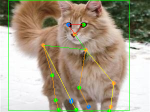

In [8]:
from mmpose.apis import (inference_top_down_pose_model, init_pose_model,
                         vis_pose_result, process_mmdet_results)
from mmdet.apis import inference_detector, init_detector
local_runtime = False
from xtcocotools.coco import COCO
from mmcv import Config
from mmpose.datasets import DatasetInfo
import cv2

try:
  from google.colab.patches import cv2_imshow  # for image visualization in colab
except:
  local_runtime = True


# initialize pose model
#pose_config = 'configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/cats/res50_cats_128x128.py'
pose_config='./mmpose/configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/cats/hrnet_w32_coco_256x192_coarsedropout.py'
#pose_checkpoint = 'work_dirs/res50_cats_128x128/latest.pth'
pose_checkpoint= 'work_dirs/hrnet_w32_coco_256x192_exp/best_AP_epoch_130.pth'
# initialize pose model
pose_model = init_pose_model(pose_config, pose_checkpoint)

# Use coco api to read the validation set 
coco = COCO('data/cats/annotations/val.json')
img_keys = list(coco.imgs.keys())
image_id =  img_keys[-1]
image = coco.loadImgs(image_id)[0]
image_name = os.path.join('data/cats/images', image['file_name'])
ann_ids = coco.getAnnIds(image_id)

config = Config.fromfile(
    './configs/_base_/cats.py'
)
dataset = pose_model.cfg.data['test']['type']
dataset_info = pose_model.cfg.data['test'].get('dataset_info', None)
if dataset_info is None:
    warnings.warn(
        'Please set `dataset_info` in the config.'
        'Check https://github.com/open-mmlab/mmpose/pull/663 for details.',
        DeprecationWarning)
else:
    dataset_info = DatasetInfo(dataset_info)


# make bounding boxes
box_results = []
for ann_id in ann_ids:
    item = {}
    ann = coco.anns[ann_id]
    # bbox format is 'xywh'
    item['bbox'] = ann['bbox']
    box_results.append(item)

# test a single image, with a list of bboxes
pose_results, returned_outputs = inference_top_down_pose_model(
    pose_model,
    image_name,
    box_results,
    bbox_thr=None,
    format='xywh',
    dataset='AnimalCatsDataset',
    dataset_info=dataset_info)


# show pose estimation results
vis_result = vis_pose_result(pose_model,
                             image_name,
                             pose_results,
                             kpt_score_thr=0.,
                             dataset='AnimalCatsDataset',
                             show=False)

# reduce image size
vis_result = cv2.resize(vis_result, dsize=None, fx=0.5, fy=0.5)

if local_runtime:
  from IPython.display import Image, display
  import tempfile
  import os.path as osp
  import cv2
  with tempfile.TemporaryDirectory() as tmpdir:
    file_name = osp.join(tmpdir, 'pose_results.png')
    cv2.imwrite(file_name, vis_result)
    display(Image(file_name))
else:
  cv2_imshow(vis_result)

### Test

In [5]:
from mmpose.datasets import build_dataset, build_dataloader
from mmpose.models import build_posenet
from mmpose.apis import single_gpu_test
from mmcv.parallel import MMDataParallel
from mmcv.runner import load_checkpoint
import os
import mmcv

# build dataset
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
test_loader_cfg = {**dict(shuffle=False, drop_last=False), 
              **dict(workers_per_gpu=cfg.data.get('workers_per_gpu', 1)),
              **dict(samples_per_gpu=cfg.data.get('samples_per_gpu', 1)),
              **cfg.data.get('test_dataloader', {})
             }
data_loader = build_dataloader(dataset, **test_loader_cfg)

# build model
model = build_posenet(cfg.model)
model = MMDataParallel(model, device_ids=[0])
load_checkpoint(model, os.path.join(cfg.work_dir, "latest.pth"), map_location='cpu')

# create work_dir
mmcv.mkdir_or_exist(cfg.work_dir)
print('hello')
# train model
outputs = single_gpu_test(model, data_loader)
dataset.evaluate(outputs, cfg.work_dir)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
=> num_images: 200
=> load 223 samples
load checkpoint from http path: https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth


2022-03-20 23:06:04,829 - mmpose - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: keypoint_head.final_layer.weight, keypoint_head.final_layer.bias



load checkpoint from local path: work_dirs/hrnet_w32_coco_256x192_exp/latest.pth
hello
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 223/223, 88.9 task/s, elapsed: 3s, ETA:     0sLoading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.000
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.000
 Average Recall     (AR) @[ IoU=0.75      | area= 

OrderedDict([('AP', 0.0),
             ('AP .5', 0.0),
             ('AP .75', 0.0),
             ('AP (M)', 0.0),
             ('AP (L)', 0.0),
             ('AR', 0.0),
             ('AR .5', 0.0),
             ('AR .75', 0.0),
             ('AR (M)', 0.0),
             ('AR (L)', 0.0)])

Please simply ignore the evaluation results (0.000). It means nothing. Since the provided "test_info.json" does not contain any ground-truth keypoint annotations, so you cannot evaluate it locally. But you can obtain the "result_keypoints.json" under the work_dir.

### For submission

Finally, you should submit the training config file, model checkpoint, the training logs. They can be found in the work_dir.
TA will running model inference on the test set, and use the mAP of the test set for final performance ranking.

In the following, I will show how to prepare the files for submission.

In [6]:
%cd ..
# change "123456" to your student ID
%mkdir 3035345411
%cd 3035345411
%mkdir models
#%cp ../mmpose/work_dirs/res50_cats_128x128/latest.pth ./models/model.pth # model checkpoint (choose the model you like.)
%cp ../COMP7606/work_dirs/hrnet_w32_coco_256x192_exp/best_AP_epoch_130.pth ./models/model.pth
%cp ../COMP7606/work_dirs/hrnet_w32_coco_256x192_exp/None.log.json ./models/ # training log
%cp ../COMP7606/mmpose/configs/animal/2d_kpt_sview_rgb_img/topdown_heatmap/cats/hrnet_w32_coco_256x192_coarsedropout.py ./models/ # config file 
%cp ../COMP7606/work_dirs/hrnet_w32_coco_256x192_exp/result_keypoints.json ./
# You also need to prepare the final report.pdf


# You also need to upload the codes and a simple README.txt describing which files are changed.
# NOTICE! Do NOT upload the dataset and the work_dirs. They are too large.

/userhome/eee/smehra2
mkdir: cannot create directory ‘3035345411’: File exists
/userhome/eee/smehra2/3035345411
mkdir: cannot create directory ‘models’: File exists
